In [32]:
import pandas as pd
from datetime import datetime, timedelta
from scipy import integrate, optimize
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

In [33]:
# data preprocessing
data = pd.read_csv('owid-covid-data.csv')
country = 'Turkey'
country_data = data[data.location == country]
country_data = country_data[(country_data['total_cases'] > 0)]
country_data.head()

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
14613,TUR,Turkey,2020-03-12,1,1,0,0,0.012,0.012,0.0,0.0,NaN,NaN,NaN,NaN,NaN
14614,TUR,Turkey,2020-03-13,2,1,0,0,0.024,0.012,0.0,0.0,NaN,NaN,NaN,NaN,NaN
14615,TUR,Turkey,2020-03-16,18,16,0,0,0.213,0.190,0.0,0.0,NaN,NaN,NaN,NaN,NaN
14616,TUR,Turkey,2020-03-17,47,29,0,0,0.557,0.344,0.0,0.0,NaN,NaN,NaN,NaN,NaN
14617,TUR,Turkey,2020-03-18,98,51,0,0,1.162,0.605,0.0,0.0,10018.0,NaN,0.119,NaN,tests performed


In [34]:
# population
pop_dict = {'United Kingdom': 67900000, 'Italy': 60500000, 'China': 1400050000, 'Turkey': 83200000}
pop = pop_dict[country]

# time interval
t_interval = np.arange(len(country_data))

# daily new cases
daily_new_cases = country_data['new_cases'].values

In [35]:
# evaluation meric
def evaluate(actual, predict):
    score = r2_score(actual, predict)
    return score

In [36]:
# SEIR model: susceptible, exposed, infected, recovered
# initial values
I0 = daily_new_cases[0]
E0 = 5 * I0
S0 = pop - I0 - E0
R0 = 0
alpha = 1/4
# beta: contagion rate
# gamma: recovery rate
# alpha: incidence rate of incubation
def SEIR(seir, t, beta, gamma):
    S, E, I, R = seir
    dsdt = - beta * I * S / pop
    dedt = beta * I * S / pop - alpha * E
    drdt = gamma * I
    didt = -(dsdt + drdt + dedt)
    return [dsdt, dedt, didt, drdt]

In [37]:
# solve SEIR
def solve_SEIR(t, beta, gamma):
    out = integrate.odeint(SEIR, [S0, E0, I0, R0], t, args=(beta, gamma))
    return out[:, 2]

# fit SEIR
popt_seir, pcov_seir = optimize.curve_fit(solve_SEIR, t_interval, daily_new_cases)

In [38]:
# generate date
start_date = country_data.date.iloc[0]
days = len(t_interval)
date_interval = [(datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days=i)) for i in range(days)]
prediction = solve_SEIR(t_interval, *popt_seir)

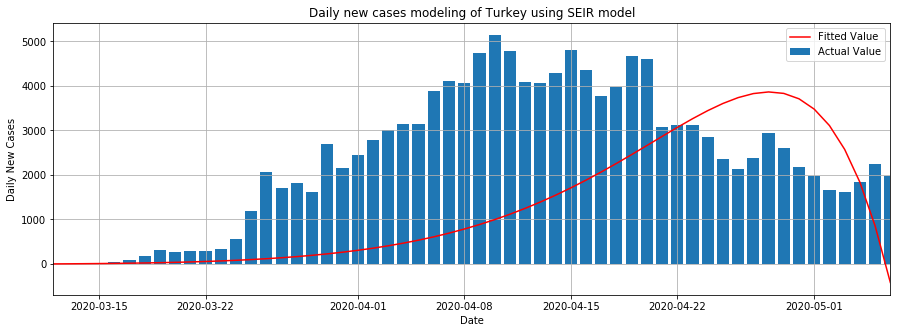

In [39]:
# visualize
plt.figure(0, figsize=(15, 5))
plt.plot(date_interval, prediction, c='r', label='Fitted Value')
plt.bar(date_interval, daily_new_cases, label='Actual Value')
plt.title('Daily new cases modeling of ' + country + ' using SEIR model')
plt.ylabel('Daily New Cases')
plt.xlabel('Date')
plt.xlim(date_interval[0], date_interval[-1])
plt.grid()
plt.legend()
plt.savefig('single_stage/' + country + '_seir.png')
plt.show()

In [40]:
# evaluate
seir_score = evaluate(daily_new_cases, prediction)
print(f'r2_score of SEIR: {seir_score}')

r2_score of SEIR: -0.5809185017211946
